In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.stats import norm
np.set_printoptions(precision=5, suppress=True)

In [205]:
import matplotlib
from math import sqrt

def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 11, # fontsize for x and y labels (was 10)
              'axes.titlesize': 11,
              'xtick.labelsize': 11,
              'ytick.labelsize': 11,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

In [206]:
df = pd.read_pickle('deribit_data.pkl')
names = list(df['instrument_name'].str.split('-'))
strike_prices = np.zeros(df.shape[0])
put_call_flag = np.zeros(df.shape[0])
dates = [None] * df.shape[0]
for i, n in enumerate(names):
    if len(n) == 2:
        strike_prices[i] = np.nan
        put_call_flag[i] = np.nan
        dates[i] = ""
    else:
        strike_prices[i] = float(n[2])
        put_call_flag[i] = 0 if n[3] == 'P' else 1
        dates[i] = n[1]
df["strike_price"] = strike_prices
df["put_call_flag"] = put_call_flag
df["date"] = dates
df = df[~df.strike_price.isna()]
df = df[(df.best_bid_amount > 0) & (df.best_ask_amount > 0)]
df = df[df.date == "27MAR20"]

In [207]:
price = df.underlying_price.mean()
df = df[np.abs(df.strike_price - price) / price < 1]

puts = df[df.put_call_flag == 0]
calls = df[df.put_call_flag == 1]
calls_bid = np.array(calls.best_bid_price) * price
calls_ask = np.array(calls.best_ask_price) * price
puts_bid = np.array(puts.best_bid_price) * price
puts_ask = np.array(puts.best_ask_price) * price
calls_strike = np.array(calls.strike_price)
puts_strike = np.array(puts.strike_price)

In [208]:
p = np.arange(5, 30005, 5)

names = ["buy put %.3f for %.3f" % (s, p) for p, s in zip(puts_ask, puts_strike)] + \
        ["write put %.3f for %.3f" % (s, p) for p, s in zip(puts_bid, puts_strike)] + \
        ["buy call %.3f for %.3f" % (s, p) for p, s in zip(calls_ask, calls_strike)] + \
        ["write call %.3f for %.3f" % (s, p) for p, s in zip(calls_bid, calls_strike)] + \
        ["buy underlying", "short underlying"]

option_fee = 0.0004
short_fee = -0.00025
long_fee = 0.00075
P = np.hstack([
    np.maximum(puts_strike[None, :] - p[:, None], 0) - option_fee,
    -np.maximum(puts_strike[None, :] - p[:, None], 0) - option_fee,
    np.maximum(p[:, None] - calls_strike[None, :], 0) - option_fee,
    -np.maximum(p[:, None] - calls_strike[None, :], 0) - option_fee,
    p[:, None],
    -p[:, None]
])
d = np.concatenate([
    puts_ask,
    -puts_bid,
    calls_ask,
    -calls_bid,
    np.array([price + long_fee * price]),
    np.array([-price + short_fee * price])
])
m, n = P.shape

print("%d puts, %d calls" % (puts_strike.size, calls_strike.size))
print ("p between %d and %d, 5 dollar increments" % (p.min(), p.max()))
print ("min strike: %d, max strike: %d" % (min(puts_strike.min(),calls_strike.min()), max(calls_strike.max(), puts_strike.max())))

16 puts, 19 calls
p between 5 and 30000, 5 dollar increments
min strike: 4000, max strike: 18000


In [209]:
# mean upper/lower bounds
pi = cp.Variable(m)
cons = [P.T @ pi <= d, cp.sum(pi) == 1, pi >= 0]

upper = cp.Problem(cp.Maximize(p @ pi), cons).solve(solver=cp.MOSEK)
lower = cp.Problem(cp.Minimize(p @ pi), cons).solve(solver=cp.MOSEK)
print("mean in [%.2f,%.2f]" % (lower, upper))

mean in [9847.65,9852.57]


7.322344843620774
short underlying 0.0010 -9847.65
buy call 9000.000 for 1191.268 0.0010 1191.27
write call 18000.000 for 19.690 0.0004 -19.69
buy call 10000.000 for 659.628 0.0004 659.63
buy call 8000.000 for 1973.960 0.0002 1973.96


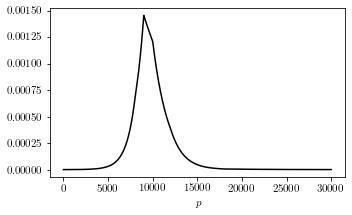

In [210]:
pi = cp.Variable(m)
entr = cp.sum(cp.entr(pi))
cons = [P.T @ pi <= d, cp.sum(pi) == 1, pi >= 0]

latexify(5)
plt.close()
res = cp.Problem(cp.Maximize(entr), cons).solve(solver=cp.MOSEK)
print (res)
pi_entr = np.copy(pi.value)
plt.plot(p, pi.value, label='entr', c='k')
plt.xlabel("$p$")
plt.tight_layout()
plt.savefig("../price_distr_derivs/figs/bitcoin_entr.pdf")
idx_dual = np.argsort(cons[0].dual_variables[0].value)
for i in idx_dual[-5:][::-1]:
    print (names[i], "%.4f" % cons[0].dual_variables[0].value[i], "%.2f" % d[i])

0 0.2441342363257214 9.30983077894366 0.24514713492170218
1 0.05445810034571652 9.174112333166958 0.2043727884654798
2 0.053935852266433604 9.173630827572063 0.2043741422060948
3 0.054170745829612565 9.173438642597507 0.2043749992809852
4 0.05455793936997122 9.173533747323848 0.2043745525611274
mu: 9.174, sigma: 0.204


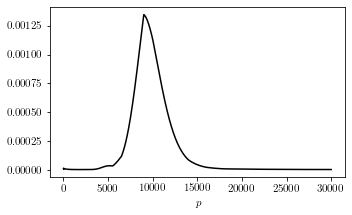

In [211]:
pilognormal = np.ones(m) / m
for k in range(5):
    mu = pilognormal @ np.log(p)
    sigma = np.sqrt(pi_entr @ np.square(np.log(p) - mu))
    nu = np.append(0, np.diff(norm.cdf(np.log(p), loc=mu, scale=sigma)))
    nu /= nu.sum()
    result = cp.Problem(cp.Minimize(cp.sum(cp.kl_div(pi, nu) + .001 * cp.sum_squares(pi - pi.value))), cons).solve(solver=cp.MOSEK)
    pilognormal = np.copy(pi.value)
    print (k, result, mu, sigma)
mu = pilognormal @ np.log(p)
sigma = np.sqrt(pi_entr @ np.square(np.log(p) - mu))
print ("mu: %.3f, sigma: %.3f" % (mu, sigma))
latexify(5)
plt.plot(p, pilognormal, c='black')
plt.xlabel('$p$')
plt.tight_layout()
plt.savefig("../price_distr_derivs/figs/bitcoin_lognormal.pdf")

In [212]:
annualized_volatility = np.std(np.prod(np.exp(np.random.normal(loc=mu, scale=sigma, size=(1_000_000, int(365/36)))) / price, axis=1))
annualized_volatility

0.7205346326594245

In [213]:
upper_bounds = []
lower_bounds = []
pi_upper = pi.value
pi_lower = pi.value
for i in np.arange(0, m, 100):
    try:
        pi.value = pi_upper
        upper_bound = cp.Problem(cp.Maximize(cp.sum(pi[:i])), cons).solve(solver=cp.MOSEK, warm_start=True)
        pi_upper = np.copy(pi.value)
    except:
        upper_bound = np.nan
    upper_bounds.append(upper_bound)
    try:
        pi.value = pi_lower
        lower_bound = cp.Problem(cp.Minimize(cp.sum(pi[:i])), cons).solve(solver=cp.MOSEK, warm_start=True)
        pi_lower = np.copy(pi.value)
    except:
        lower_bound = np.nan
    lower_bounds.append(lower_bound)

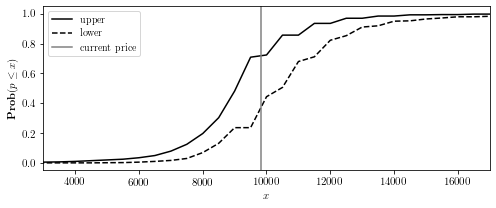

In [214]:
plt.close()
latexify(7, 3)
plt.plot(p[::100], upper_bounds, c='black', label='upper')
plt.plot(p[::100], lower_bounds, '--', c='black', label='lower')
plt.axvline(price, c='gray', label='current price')
plt.xlim(3000, 17000)
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\mathbf{Prob}(p \leq x)$')
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_cdf_bounds.pdf')
plt.show()

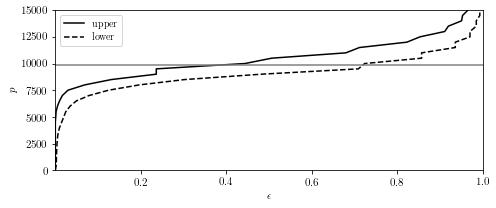

In [215]:
latexify(7, 3)
plt.plot(lower_bounds, p[::100], c='black', label='upper')
plt.plot(upper_bounds, p[::100], '--', c='black', label='lower')
plt.legend()
plt.xlim(.00001, 1)
plt.ylim(0,15000)
plt.axhline(price, c='gray', label='current price')
plt.xlabel('$\epsilon$')
plt.ylabel('$p$')
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_var_bounds.pdf')

In [216]:
ccdf_upper_bounds = []
ccdf_lower_bounds = []
pi_upper = pi.value
pi_lower = pi.value
for i in np.arange(0, m, 100):
    try:
        pi.value = pi_upper
        upper_bound = cp.Problem(cp.Maximize(cp.sum(pi[i:])), cons).solve(solver=cp.MOSEK, warm_start=True)
        pi_upper = np.copy(pi.value)
    except:
        upper_bound = np.nan
    ccdf_upper_bounds.append(upper_bound)
    try:
        pi.value = pi_lower
        lower_bound = cp.Problem(cp.Minimize(cp.sum(pi[i:])), cons).solve(solver=cp.MOSEK, warm_start=True)
        pi_lower = np.copy(pi.value)
    except:
        lower_bound = np.nan
    ccdf_lower_bounds.append(lower_bound)

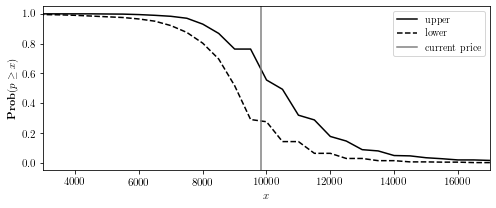

In [217]:
latexify(7, 3)
plt.plot(p[::100], ccdf_upper_bounds, c='black', label='upper')
plt.plot(p[::100], ccdf_lower_bounds, '--', c='black', label='lower')
plt.axvline(price, c='gray', label='current price')
plt.xlim(3000, 17000)
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\mathbf{Prob}(p \geq x)$')
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_ccdf_bounds.pdf')
plt.show()

In [218]:
ask_lower_bounds = []
bid_upper_bounds = []
for i in range(puts_ask.size):
    idx = np.ones(n, dtype=bool)
    idx[i] = False
    idx[puts_ask.size + i] = False
    pi = cp.Variable(m)
    cbuy = cp.Variable()
    csell = cp.Variable()
    
    cons = [pi >= 0, cp.sum(pi) == 1, P[:,idx].T @ pi <= d[idx], csell <= cbuy,
            P[:,~idx].T @ pi <= cp.vstack([cbuy, -csell])[:,0]]
    ask_lower_bound = cp.Problem(cp.Minimize(cbuy), cons).solve(solver=cp.MOSEK)
    bid_upper_bound = cp.Problem(cp.Maximize(csell), cons).solve(solver=cp.MOSEK)
    
    ask_lower_bounds.append(ask_lower_bound)
    bid_upper_bounds.append(bid_upper_bound)

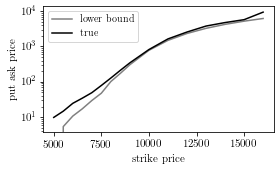

In [219]:
idx = np.argsort(puts_strike)
latexify(4)
plt.semilogy()
plt.plot(puts_strike[idx], np.array(ask_lower_bounds)[idx], label='lower bound', c='gray')
plt.plot(puts_strike[idx], puts_ask[idx], label='true', c='black')
plt.ylabel('put ask price')
plt.xlabel('strike price')
plt.legend()
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_put_ask_bounds.pdf')

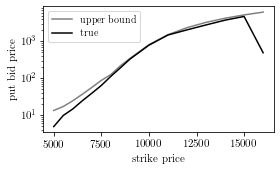

In [220]:
plt.semilogy()
latexify(4)
plt.plot(puts_strike[idx], np.array(bid_upper_bounds)[idx], label='upper bound', c='gray')
plt.plot(puts_strike[idx], puts_bid[idx], label='true', c='black')
plt.ylabel('put bid price')
plt.xlabel('strike price')
plt.legend()
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_put_bid_bounds.pdf')

In [221]:
call_ask_lower_bounds = []
call_bid_upper_bounds = []
for i in range(calls_ask.size):
    idx = np.ones(n, dtype=bool)
    idx[puts_ask.size*2 + i] = False
    idx[puts_ask.size*2 + calls_ask.size + i] = False
    pi = cp.Variable(m)
    cbuy = cp.Variable()
    csell = cp.Variable()
    
    cons = [pi >= 0, cp.sum(pi) == 1, P[:,idx].T @ pi <= d[idx], csell <= cbuy,
            P[:,~idx].T @ pi <= cp.vstack([cbuy, -csell])[:,0]]
    ask_lower_bound = cp.Problem(cp.Minimize(cbuy), cons).solve(solver=cp.MOSEK)
    bid_upper_bound = cp.Problem(cp.Maximize(csell), cons).solve(solver=cp.MOSEK)
    
    call_ask_lower_bounds.append(ask_lower_bound)
    call_bid_upper_bounds.append(bid_upper_bound)
    assert calls_ask[i] >= ask_lower_bound
    assert calls_bid[i] <= bid_upper_bound

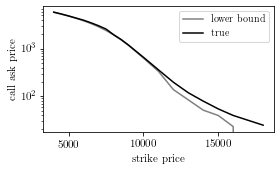

In [222]:
idx = np.argsort(calls_strike)
latexify(4)
plt.semilogy()
plt.plot(calls_strike[idx], np.array(call_ask_lower_bounds)[idx], label='lower bound', c='gray')
plt.plot(calls_strike[idx], calls_ask[idx], label='true', c='black')
plt.ylabel('call ask price')
plt.xlabel('strike price')
plt.legend()
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_call_ask_bounds.pdf')

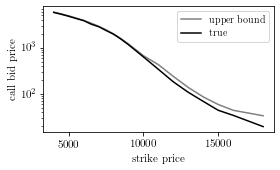

In [223]:
latexify(4)
plt.semilogy()
plt.plot(calls_strike[idx], np.array(call_bid_upper_bounds)[idx], label='upper bound', c='gray')
plt.plot(calls_strike[idx], calls_bid[idx], label='true', c='black')
plt.ylabel('call bid price')
plt.xlabel('strike price')
plt.legend()
plt.tight_layout()
plt.savefig('../price_distr_derivs/figs/bitcoin_call_bid_bounds.pdf')